Graubild-Kanten: torch.Size([1, 1, 822, 896])
RGB-Kanten: torch.Size([1, 3, 822, 896])
torch.Size([1, 1, 822, 896])


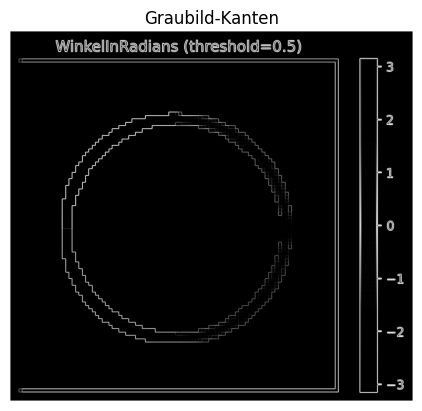

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


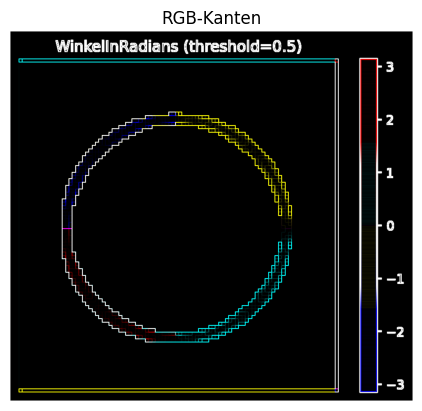

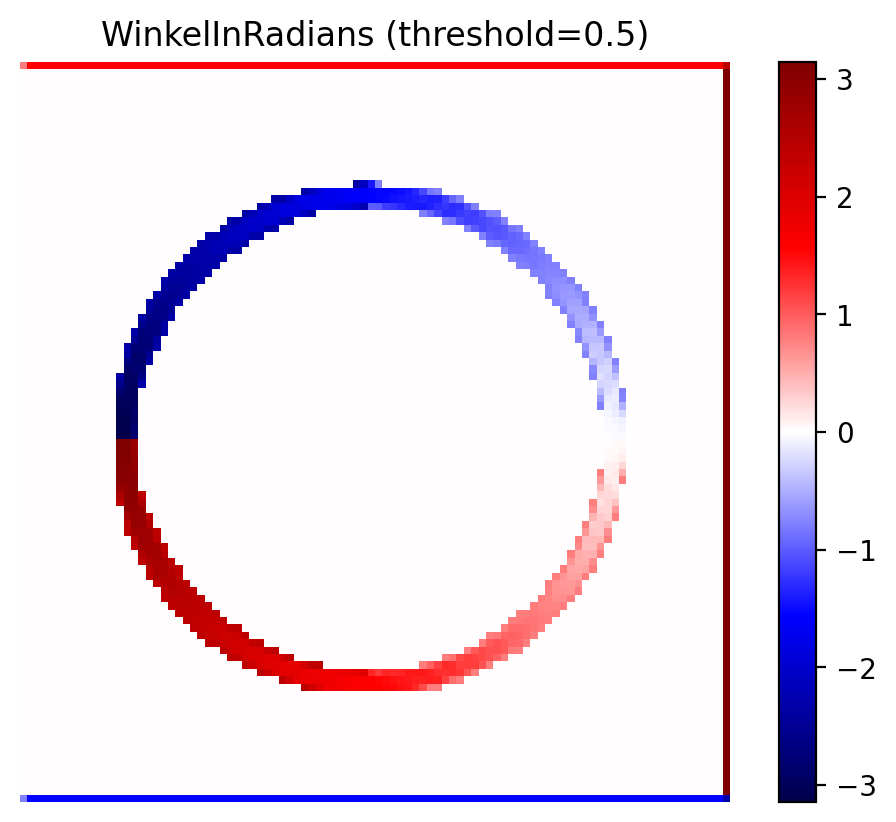

In [23]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np

# Beispiel: zufälliges RGB-Bild (Batch=1, Channels=3, Höhe=5, Breite=5)
img = Image.open("WinkelInRadians.png").convert("RGB")
img = torch.from_numpy(np.array(img)).float() / 255.0  # (H, W, C), float32, [0,1]
img = img.permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)

# ============================================================
# 1) Sobel auf Graubild (Ergebnis: 1 Kanal, nur Grauwerte)
# ============================================================

# RGB -> Grau (einfache Luminanz-Gewichtung)
weights = torch.tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)  # (1,3,1,1)
gray = (img * weights).sum(dim=1, keepdim=True)  # (1,1,H,W)
gray = (img * weights).sum(dim=1, keepdim=True)  # (1,1,H,W)

# Sobel-Kerne definieren (x- und y-Richtung)
sobel_x = torch.tensor([[-1., 0., 1.],
                        [-2., 0., 2.],
                        [-1., 0., 1.]]).view(1, 1, 3, 3)  # (out=1, in=1,3,3)

sobel_y = torch.tensor([[-1., -2., -1.],
                        [ 0.,  0.,  0.],
                        [ 1.,  2.,  1.]]).view(1, 1, 3, 3)

# Faltung (Padding=1, damit Größe gleich bleibt)
gx = F.conv2d(gray, sobel_x, padding=1)
gy = F.conv2d(gray, sobel_y, padding=1)

# Gradientenbetrag (Kantenstärke)
grad_mag_gray = torch.sqrt(gx ** 2 + gy ** 2)

print("Graubild-Kanten:", grad_mag_gray.shape)  # -> (1, 1, H, W)



# ============================================================
# 2) Sobel kanalweise auf RGB (Ergebnis: 3 Kanäle, „farbige“ Kanten)
# ============================================================

# Gleiche Sobel-Filter, aber für 3 Kanäle mit groups=3
#   Gewicht-Shape: (out_channels, in_channels/groups, kH, kW)
sobel_x_rgb = sobel_x.repeat(3, 1, 1, 1)  # (3,1,3,3)
sobel_y_rgb = sobel_y.repeat(3, 1, 1, 1)

gx_rgb = F.conv2d(img, sobel_x_rgb, padding=1, groups=3)  # (1,3,H,W)
gy_rgb = F.conv2d(img, sobel_y_rgb, padding=1, groups=3)  # (1,3,H,W)

grad_mag_rgb = torch.sqrt(gx_rgb ** 2 + gy_rgb ** 2)

print("RGB-Kanten:", grad_mag_rgb.shape)  # -> (1, 3, H, W)

#show image
import matplotlib.pyplot as plt
def show_image(tensor, title="Image"):
    tensor = tensor.squeeze()
    if tensor.dim() == 2:
        img = tensor.cpu().numpy()
        plt.imshow(img, cmap='gray')
    elif tensor.dim() == 3:
        img = tensor.permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
    else:
        raise ValueError("Unsupported tensor shape for image display.")
    plt.title(title)
    plt.axis('off')
    plt.show()

print(grad_mag_gray.shape)

show_image(grad_mag_gray.squeeze(0), title="Graubild-Kanten")
show_image(grad_mag_rgb, title="RGB-Kanten")

Image.open("WinkelInRadians.png").convert("RGB")
